In [1]:
from project_paths import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GroupShuffleSplit, GridSearchCV, KFold, ParameterGrid
from sklearn.metrics import make_scorer, fbeta_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

import xgboost
from sklearn.inspection import permutation_importance

In [2]:
best_model = load_list_from_pkl('xgb_best_model.pkl')

### Feature importances according to XGBoost -> basic 

In [17]:
len(best_model.feature_importances_), len(best_model.get_booster().feature_names)

(60, 60)

In [18]:
X_other = load_list_from_pkl('X_other.pkl')
y_other = load_list_from_pkl('y_other.pkl')
X_holdout = load_list_from_pkl('X_holdout.pkl')
y_holdout = load_list_from_pkl('y_holdout.pkl')

In [19]:
# Preprocessor
onehot_ftrs = load_list_from_pkl('onehot_ftrs.pkl')
minmax_ftrs = load_list_from_pkl('minmax_ftrs.pkl')
standard_ftrs = load_list_from_pkl('standard_ftrs.pkl')

preprocessor = ColumnTransformer(
    transformers=[('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), onehot_ftrs), 
                 ('minmax', MinMaxScaler(), minmax_ftrs),
                 ('standard', StandardScaler(), standard_ftrs),])

In [20]:
m = best_model

X_train_prep = preprocessor.fit_transform(X_other)
X_test_prep = preprocessor.transform(X_holdout)
y_train = y_other
y_test = y_holdout
feature_names = list(preprocessor.named_transformers_['onehot'].get_feature_names()) + \
            preprocessor.transformers[1][-1] + preprocessor.transformers[2][-1]
df_train = pd.DataFrame(data=X_train_prep, columns = feature_names)
df_test = pd.DataFrame(data=X_test_prep, columns = feature_names)

RANDOM_STATE = 10
eval_set = [(df_test, y_test)]
m.random_state=RANDOM_STATE
m.fit(df_train, y_train, early_stopping_rounds=50, eval_set=eval_set, verbose=False)

[14:23:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9,
              eval_metric=make_scorer(fbeta_score, beta=1.5), gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=7, num_parallel_tree=1, random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=25,
              subsample=0.66, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

### Feature importance by random permutation

In [21]:
result = permutation_importance(m, df_train, y_train, n_repeats=10, random_state=RANDOM_STATE)

In [22]:
perm_importances = list(result['importances_mean'])
perm_importances_fn = m.get_booster().feature_names
perm_importances_dict = {n:i for n, i in zip(perm_importances_fn, perm_importances)}

### Feature importances using XGB total_gain and weight

In [23]:
total_gain_scores = m.get_booster().get_score(importance_type='total_gain')
weight_scores = m.get_booster().get_score(importance_type='weight')

### Collating feature importances of each feature for each type

In [24]:
feature_importances = {}
for fn in feature_names:
    feature_importances[fn] = {
        'permutation': perm_importances_dict[fn],
        'gain': total_gain_scores[fn],
        'weight': weight_scores[fn],
    }

### Bar plot for feature importances

In [25]:
# First find the top 10 by each metric
most_important_features = []
for t in ['permutation', 'gain', 'weight']:
    type_dict = {k: v[t] for k, v in feature_importances.items()}
    most_important_features += [k for k, v in sorted(type_dict.items(), key=lambda item: item[1])[:10]]

most_important_features = list(set(most_important_features))

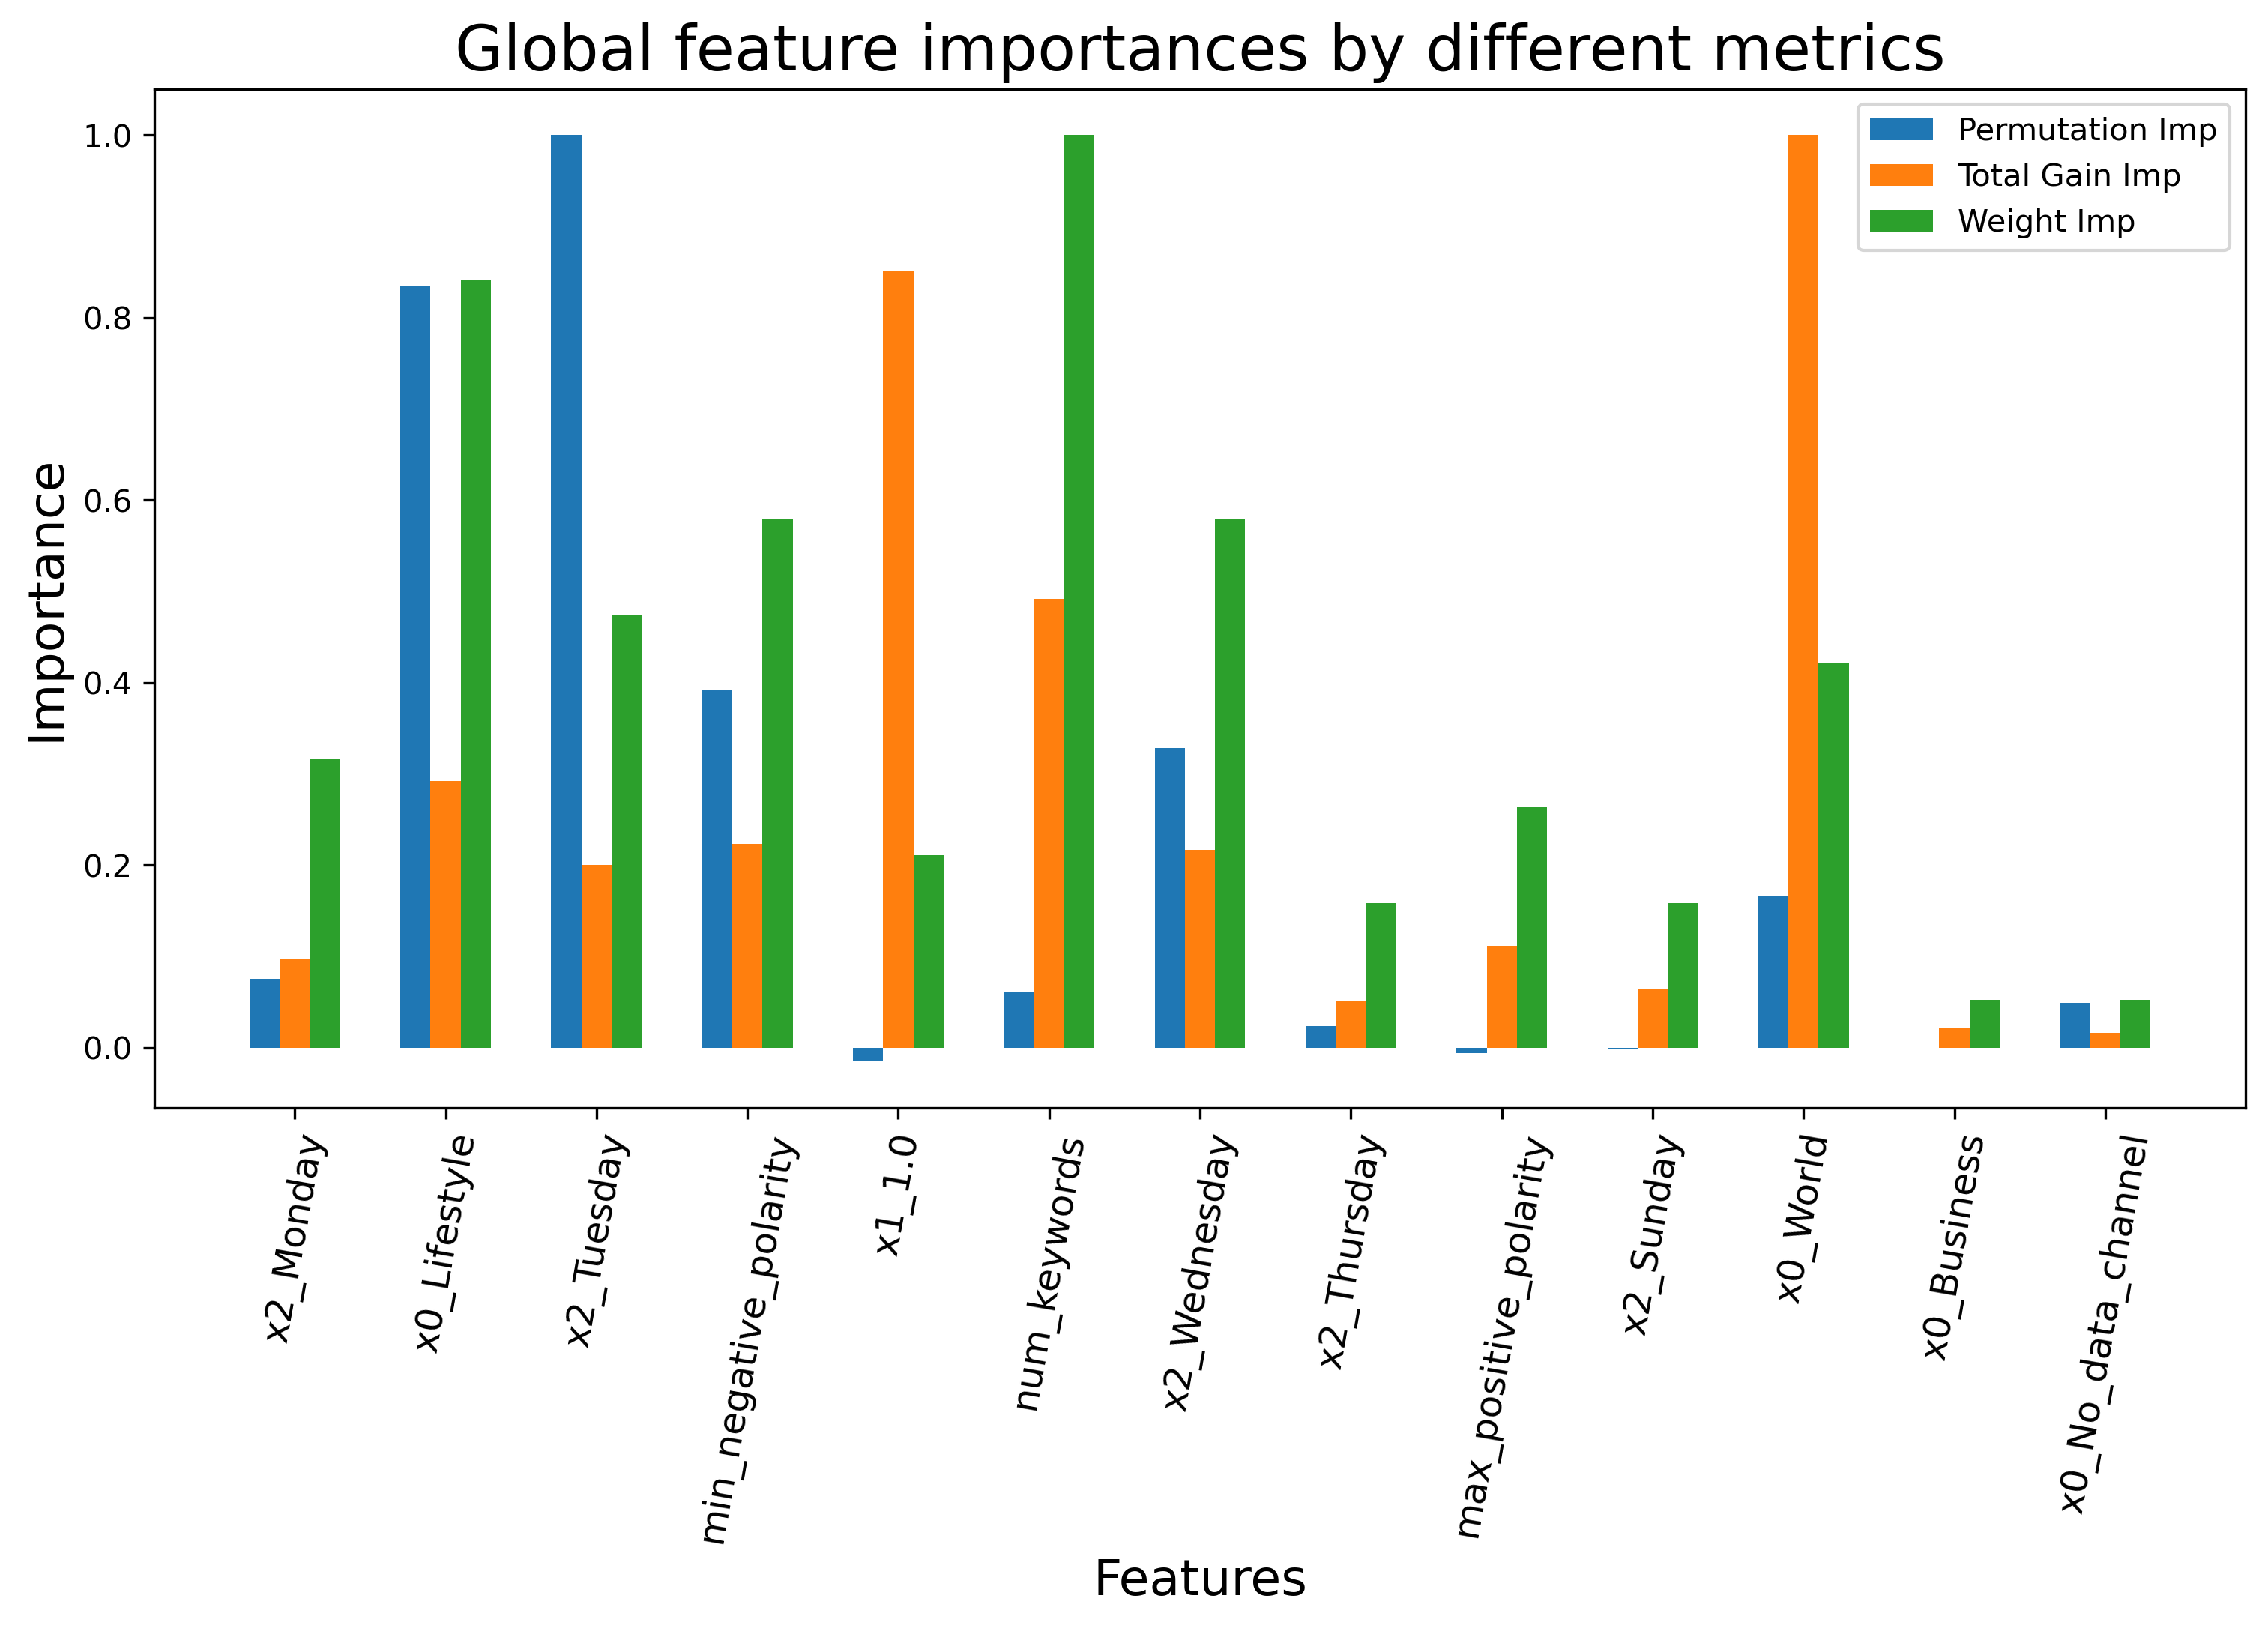

In [28]:
# Ygirls = [10,20,20,40]
# Zboys = [20,30,25,30]
perm_scores = [feature_importances[f]['permutation'] for f in most_important_features]
perm_scores = [x/np.max(perm_scores) for x in perm_scores]
total_gain_scores = [feature_importances[f]['gain'] for f in most_important_features]
total_gain_scores = [x/np.max(total_gain_scores) for x in total_gain_scores]
weight_scores = [feature_importances[f]['weight'] for f in most_important_features]
weight_scores = [x/np.max(weight_scores) for x in weight_scores]
  
X_axis = np.arange(len(most_important_features))

f, ax = plt.subplots(figsize=(12,6))
plt.bar(X_axis - 0.2, perm_scores, 0.2, label = 'Permutation Imp')
plt.bar(X_axis + 0.0, total_gain_scores, 0.2, label = 'Total Gain Imp')
plt.bar(X_axis + 0.2, weight_scores, 0.2, label = 'Weight Imp')
  
plt.xticks(X_axis, most_important_features)
plt.xlabel("Features", fontsize=16)
plt.xticks(fontsize=12, rotation=80)
plt.ylabel("Importance", fontsize=16)
plt.title("Global feature importances by different metrics", fontsize=20)
plt.legend()
# plt.show()
plt.savefig(figures_dir + 'feature_importances.png', bbox_inches='tight')

### Using SHAP for global feature importance

In [9]:
import shap
shap.initjs() # required for visualizations later on

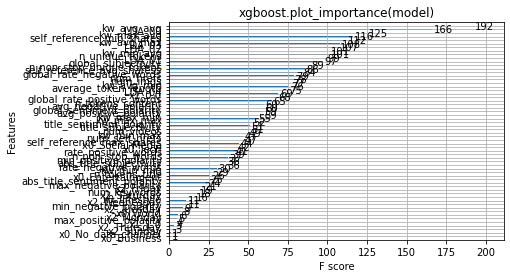

In [18]:
# Testing XGB importance plot
xgboost.plot_importance(m, importance_type="weight")
plt.title("xgboost.plot_importance(model)")
plt.show()

In [10]:
explainer = shap.TreeExplainer(m)
shap_values = explainer.shap_values(df_test)

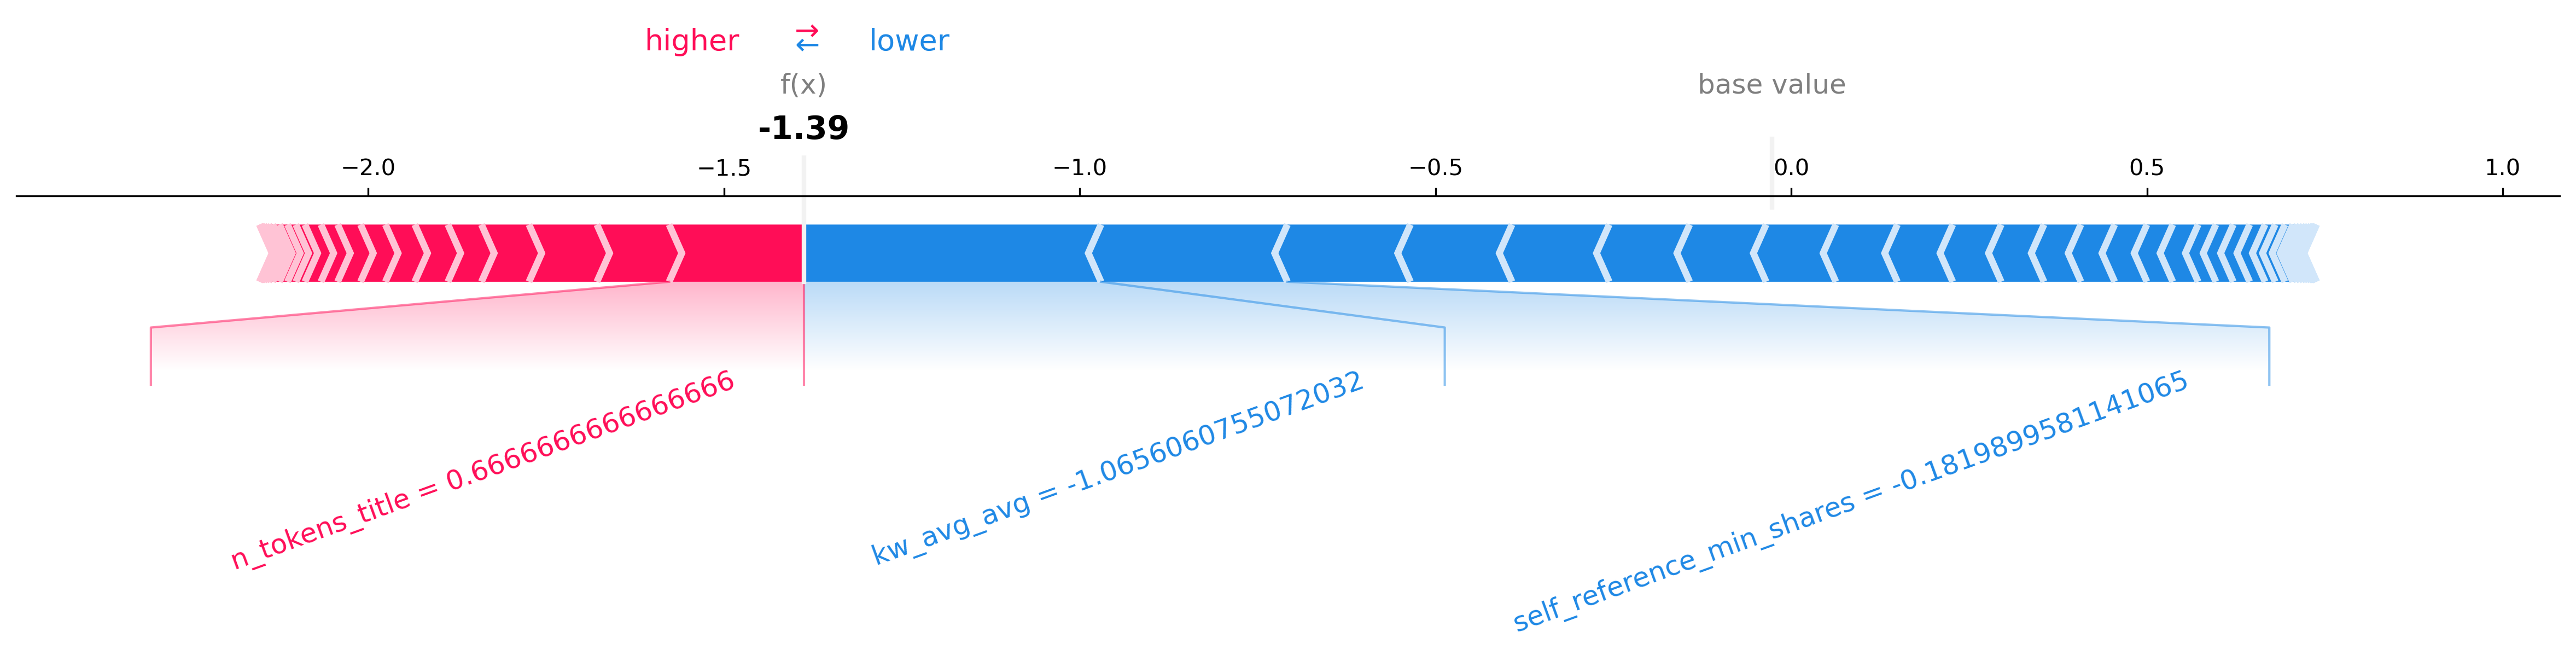

In [88]:
n = 0
shap.force_plot(explainer.expected_value, shap_values[n,:], df_test.iloc[n,:],show=False,matplotlib=True, text_rotation=20)\
    .savefig(figures_dir + 'SHAP_local_1.png', format = "png",dpi = 300,bbox_inches = 'tight')

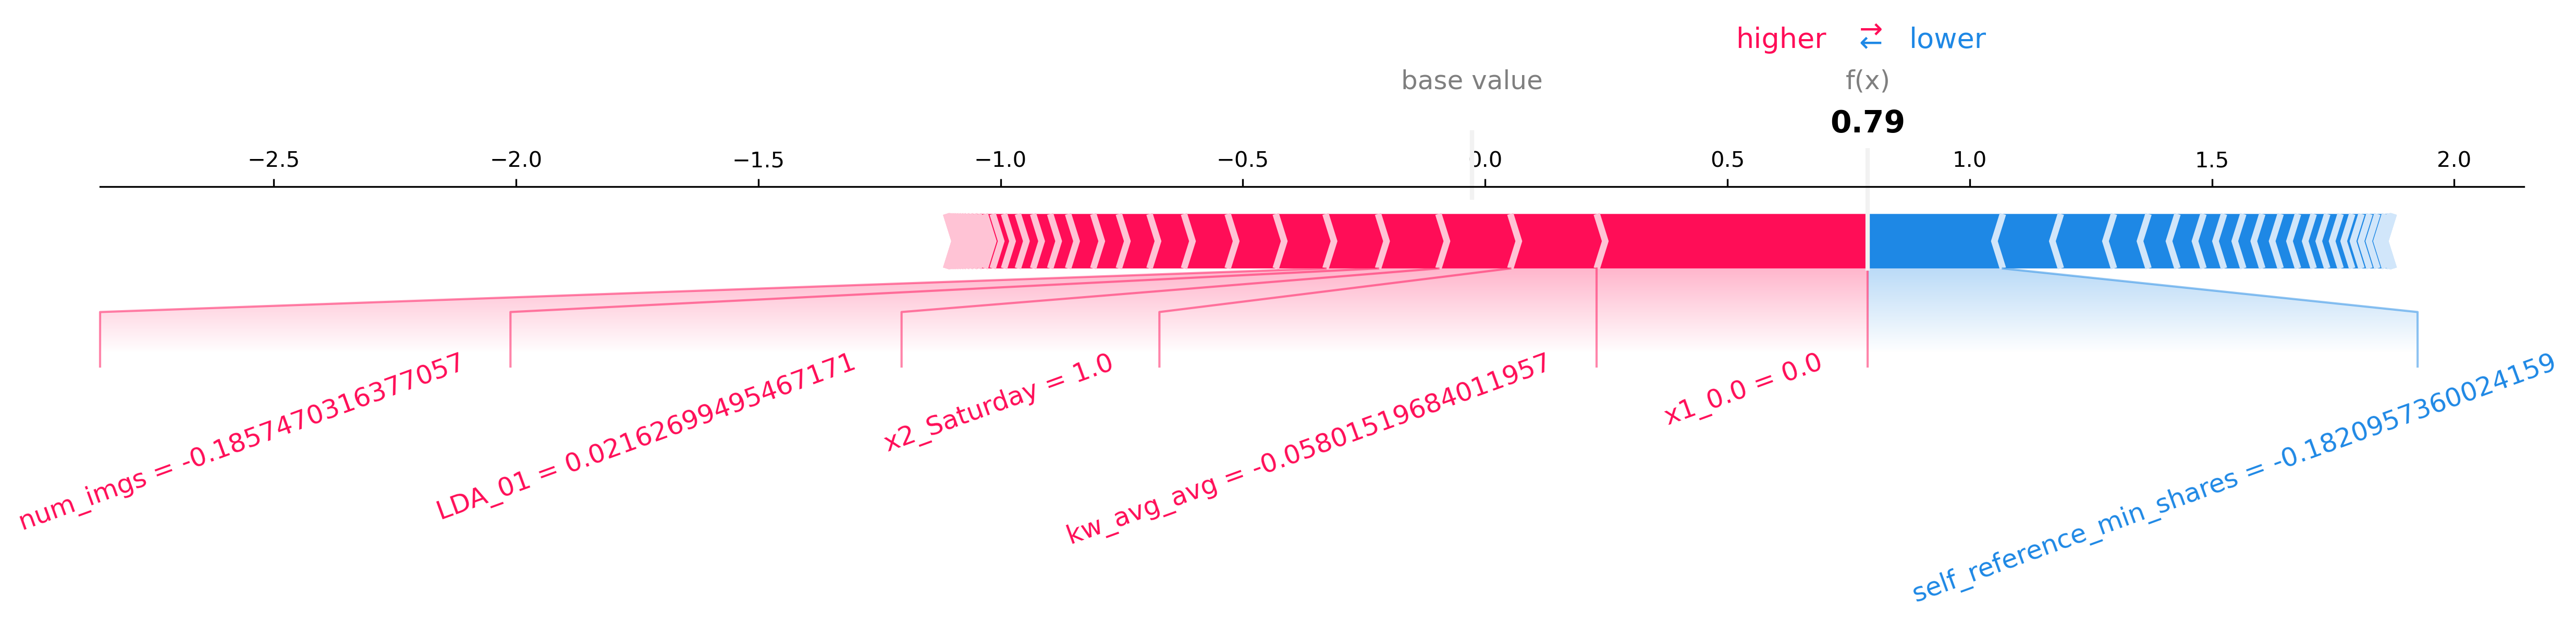

In [87]:
n = 40
# shap.force_plot(explainer.expected_value, shap_values[n,:], df_test.iloc[n,:])
shap.force_plot(explainer.expected_value, shap_values[n,:], df_test.iloc[n,:],show=False,matplotlib=True, text_rotation=20)\
    .savefig(figures_dir + 'SHAP_local_2.png', format = "png",dpi = 300,bbox_inches = 'tight')

In [34]:
shap.force_plot(explainer.expected_value, shap_values[:20,:], df_test.iloc[:20,:])

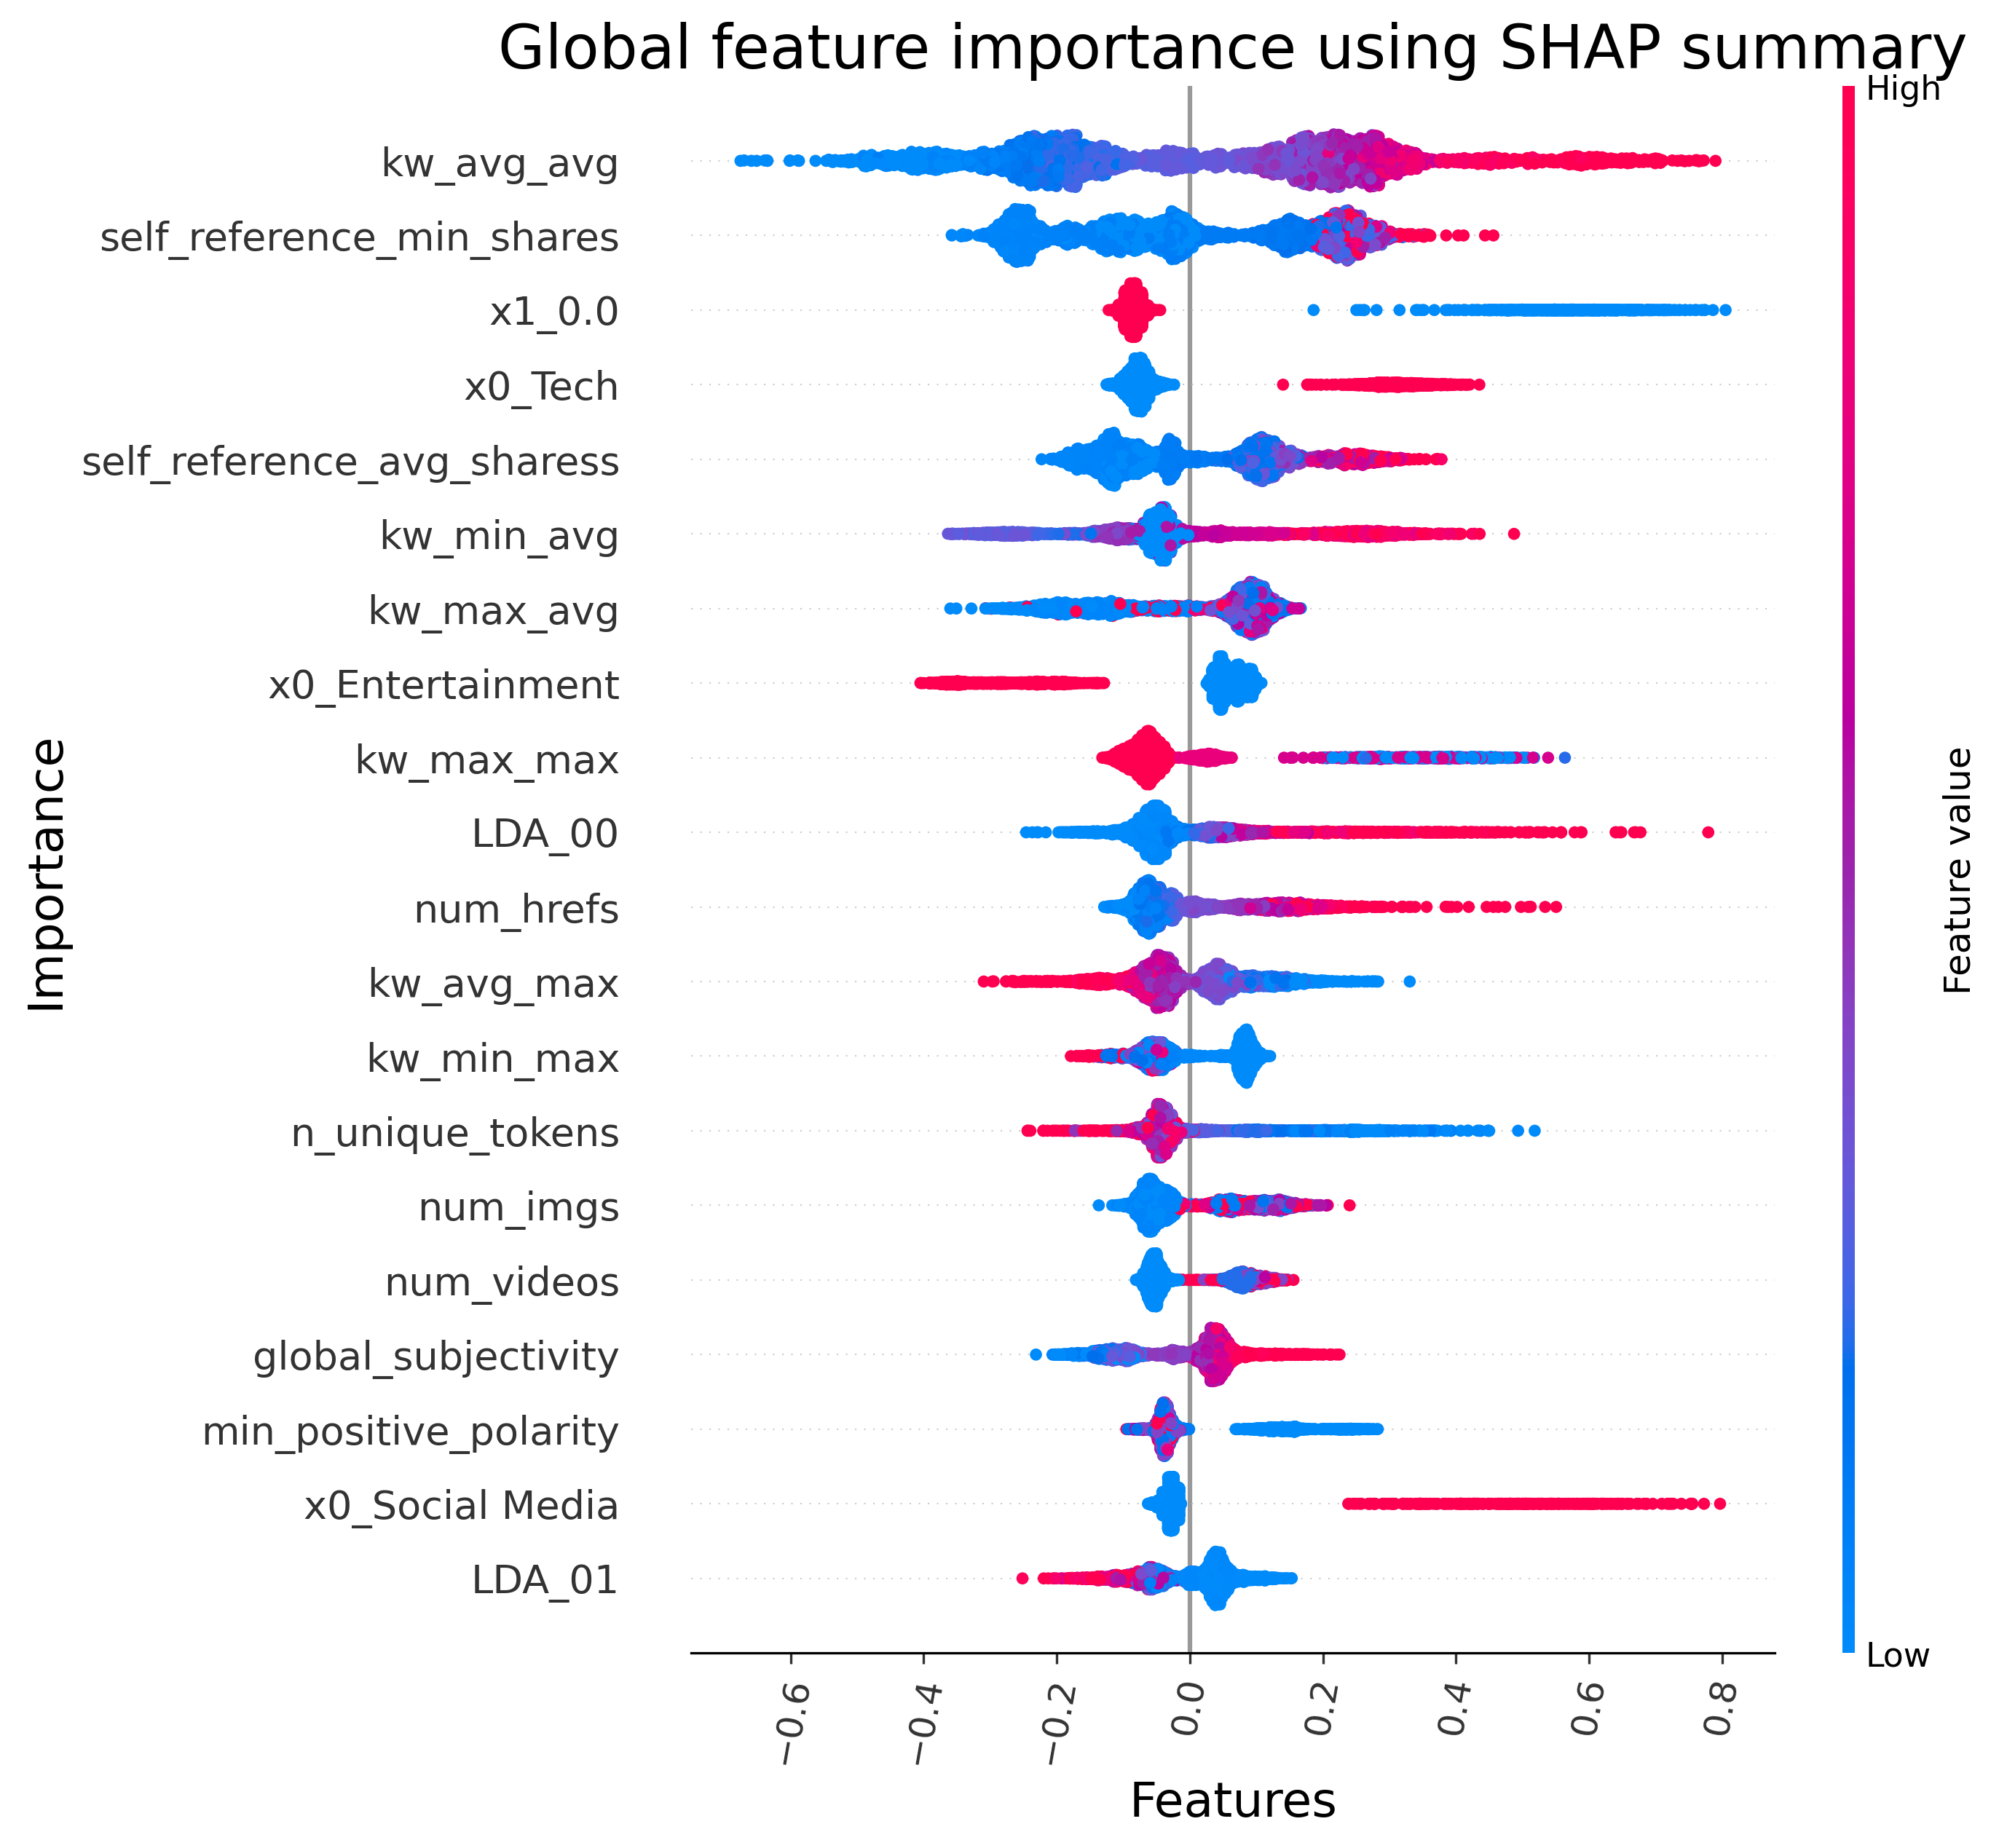

In [16]:
shap.summary_plot(shap_values, df_test, class_names=['A', 'B'], show=False)
plt.xlabel("Features", fontsize=16)
plt.xticks(fontsize=12, rotation=80)
plt.ylabel("Importance", fontsize=16)
plt.rcParams["figure.dpi"] = 300
plt.title("Global feature importance using SHAP summary", fontsize=20)
plt.savefig(figures_dir+'SHAP_summary.png', bbox_inches='tight')

In [ ]:
# create the explainer object with the random forest model
explainer = shap.TreeExplainer(grid.best_estimator_[1])
# transform the test set
X_test_transformed = grid.best_estimator_[0].transform(X_test)
print(np.shape(X_test_transformed))
# calculate shap values on the first 1000 points in the test
shap_values = explainer.shap_values(X_test_transformed[:1000])
print(np.shape(shap_values))

In [ ]:
shap.summary_plot(shap_values, X_test_transformed[:1000],feature_names = feature_names)

## Randomness due to XGBoost

In [34]:
BETA = 1.5
m = best_model

X_train_prep = preprocessor.fit_transform(X_other)
y = y_other
feature_names = list(preprocessor.named_transformers_['onehot'].get_feature_names()) + \
            preprocessor.transformers[1][-1] + preprocessor.transformers[2][-1]
df = pd.DataFrame(data=X_train_prep, columns = feature_names)

random_states = range(10)
scores = []
for RANDOM_STATE in random_states:
    df_train, df_test, y_train, y_test = train_test_split(df, y, train_size = 0.9, random_state=RANDOM_STATE)
    eval_set = [(df_test, y_test)]
    m.random_state=RANDOM_STATE
    m.fit(df_train, y_train, early_stopping_rounds=50, eval_set=eval_set, verbose=False)
    y_test_pred = m.predict(df_test, ntree_limit=m.best_ntree_limit)
    scores.append(fbeta_score(y_test, y_test_pred, beta=BETA))

[17:57:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:58:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:58:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:58:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[0.6530072703238599,
 0.6712632677918914,
 0.6699211908931698,
 0.6423858893227413,
 0.663903743315508,
 0.658668162789694,
 0.6790793897077837,
 0.6540916494255403,
 0.6741079275795395,
 0.6607860262008733]

In [37]:
print("Randomness due to non deterministic nature of XGBoost")
np.std(scores)

Randomness due to non deterministic nature of XGBoost


0.010611218478763718